In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('Clustering_dataset.xlsx')

print("Data Shape:")
print(df.shape)

print("Data Preview:")
print(df.head())

print("Data Summary:")
print(df.describe())

Data Shape:
(200, 5)
Data Preview:
   CustomerID   Genre   Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male  19.0                15.0                    39.0
1           2    Male  21.0                 NaN                    81.0
2           3  Female  20.0                16.0                     6.0
3           4  Female  23.0                16.0                    77.0
4           5  Female  31.0                17.0                    40.0
Data Summary:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  194.000000          194.000000              194.000000
mean   100.500000   38.731959           60.814433               50.350515
std     57.879185   14.019243           26.394901               26.176183
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.250000           40.500000               34.250000
50%    100.500000   36.000000           62.000000               50.000000
7

I think they expected us to fill in the missing data.


In [ ]:
#To check which columns have missing values
df.isnull().sum()



CustomerID                0
Genre                     6
Age                       6
Annual Income (k$)        6
Spending Score (1-100)    6
dtype: int64

In [ ]:
import numpy as np
import pandas as pd

class KMeansCustom:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels = None

    def fit(self, X):
        X = np.array(X, float)
        n_samples, n_features = X.shape

        # init centroids from data
        random_idx = np.random.choice(n_samples, self.k, replace=False)
        centroids = X[random_idx].copy()

        for _ in range(self.max_iters):
            # assign
            distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
            labels = np.argmin(distances, axis=1)

            # recompute keep old centroid if a cluster is empty
            new_centroids = centroids.copy()
            for i in range(self.k):
                mask = (labels == i)
                if np.any(mask):
                    new_centroids[i] = X[mask].mean(axis=0)

            # convergence by centroid movement
            if np.linalg.norm(new_centroids - centroids) <= self.tol:
                centroids = new_centroids
                break
            centroids = new_centroids

        self.centroids = centroids
        self.labels = labels  

    def predict(self, X):
        X = np.array(X, float)
        distances = np.linalg.norm(X[:, None, :] - self.centroids[None, :, :], axis=2)
        return np.argmin(distances, axis=1)

    def getCost(self, X):
        X = np.array(X, float)
        # recompute labels for this X 
        labels = self.predict(X)
        diffs = X - self.centroids[labels]
        return float(np.sum(diffs * diffs))


In [ ]:
# Encode Genre 
df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})

# Drop rows with ANY NaN across all columns cause doing just the average might not be good for 
# clustering as we will be putting some values without knowing any realtion between them.
before = len(df)

df = df.dropna(axis=0, how='any').reset_index(drop=True)

print(f"Removed {before - len(df)} rows with NaN.")

# Dropping CustomerID as it is not useful for clustering
X = df.drop(columns=['CustomerID']).to_numpy(dtype=float)

# Run KMeans
kmeans = KMeansCustom(k=3)
kmeans.fit(X)

print("Centroids:\n", kmeans.centroids)
print("Labels:\n", kmeans.labels)
print("Cost (WCSS):", kmeans.getCost(X))


   CustomerID  Genre   Age  Annual Income (k$)  Spending Score (1-100)
0           1    0.0  19.0                15.0                    39.0
1           2    0.0  21.0                 NaN                    81.0
2           3    1.0  20.0                16.0                     6.0
3           4    1.0  23.0                16.0                    77.0
4           5    1.0  31.0                17.0                    40.0
Removed 22 rows with NaN.
Centroids:
 [[ 0.42424242 41.39393939 87.45454545 17.54545455]
 [ 0.51351351 32.78378378 86.78378378 81.89189189]
 [ 0.60185185 39.75       43.49074074 49.12962963]]
Labels:
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0
 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1]
Cost (WCSS)

K-Means was implemented from scratch with three main steps: initializing centroids by randomly selecting k points, assigning each data point to the nearest centroid using Euclidean distance, and updating each centroid as the mean of its cluster. These steps were repeated until convergence (centroids moving less than a small tolerance) or until the maximum number of iterations was reached. The performance of clustering was measured using the Within-Cluster Sum of Squares (WCSS), which represents how compact the clusters are.

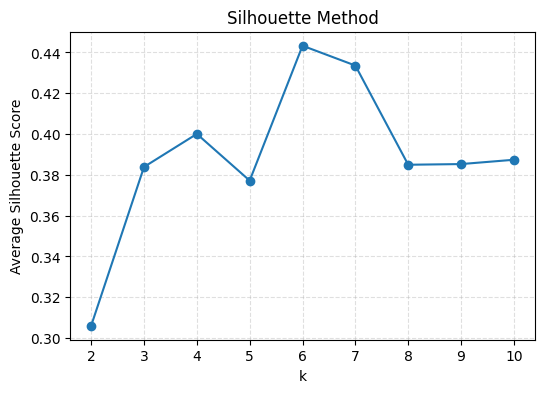

In [ ]:
#Q2.2b
from sklearn.metrics import silhouette_score

k_list = list(range(2, 11))
sil_scores = []

for k in k_list:
    km = KMeansCustom(k=k, max_iters=100, tol=1e-4)
    km.fit(X)
    labels = km.labels
    # silhouette needs >= 2 clusters and < n_samples as the formula is b(i) - a(i) / max(a(i), b(i))
    # A good score should reward low within-cluster distance and high between-cluster distance. s0 [-1,1]
    if len(np.unique(labels)) < 2 or len(np.unique(labels)) >= len(X):
        sil_scores.append(np.nan)
    else:
        sil_scores.append(silhouette_score(X, labels))

# plot
plt.figure(figsize=(6,4))
plt.plot(k_list, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Method")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()



The average silhouette scores were highest at k = 6, indicating that this choice of clusters produces the best separation between groups while maintaining tight cohesion within clusters. Scores for other values of k were lower, meaning those clusterings were less well-structured. Therefore, the silhouette method supports k = 6 as the optimal number of clusters.

k = 1, WCSS = 285953.24
k = 2, WCSS = 209283.40
k = 3, WCSS = 152199.86
k = 4, WCSS = 97170.00
k = 5, WCSS = 91096.36
k = 6, WCSS = 61058.82
k = 7, WCSS = 47169.39
k = 8, WCSS = 52518.74
k = 9, WCSS = 57161.16
k = 10, WCSS = 35028.03


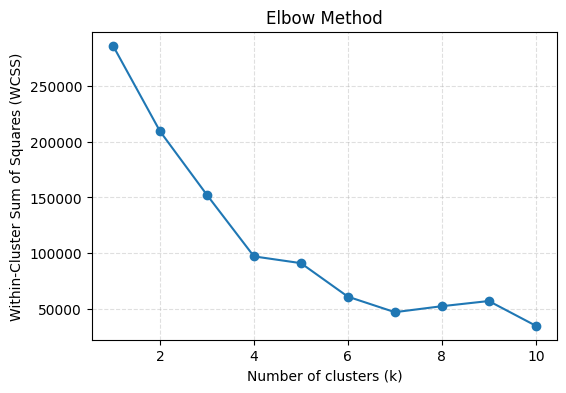

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# range of k values to test
k_list = list(range(1, 11))   
wcss_list = []

# As k increases, WCSS always decreases (clusters get smaller/tighter).
# The goal is to look for a sharp bend, after which improvements become marginal.

for k in k_list:
    km = KMeansCustom(k=k, max_iters=100, tol=1e-4)
    km.fit(X)
    cost = km.getCost(X)      # WCSS for this k
    wcss_list.append(cost)
    print(f"k = {k}, WCSS = {cost:.2f}")


# plot WCSS vs k
plt.figure(figsize=(6,4))
plt.plot(k_list, wcss_list, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


The WCSS decreased quickly for the first few values of k and then started to flatten out. The curve showed a clear “elbow” around k = 6, after which the reduction in WCSS became much smaller. This suggests that six clusters provide a good balance between compactness of clusters and model simplicity.